# Setup
## Downloading Packages

In [1]:
# To install the kaggle package in the notebook WARNING Installs System wide
# Download API key from Kaggle from Accounts - Create New Api Token
# Move the downloaded kaggle.json to ~/.kaggle/

# import sys
# !{sys.executable} -m pip install kaggle

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

color = sns.color_palette()
%matplotlib inline

## Downloading Instacart data using the Kaggle API
Unzipping and Cleaning CSV zip files

In [2]:
# Downloading CSV data, unzipping and moving to csv_src folder

# After isntalling the kaggle module and setting kaggle.json api keys
# Download the dataset from the Kaggle
!kaggle competitions download -c instacart-market-basket-analysis

# Custom shell script to unzip all files, remove zips and move csv into csv_src
# The unzip_rm.sh script should be in the same directory as the python notebook file
!chmod u+x unzip_rm.sh
!./unzip_rm.sh

  0%|                                                 | 0.00/804 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 804/804 [00:00<00:00, 362kB/s]
  0%|                                               | 0.00/1.87k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.87k/1.87k [00:00<00:00, 578kB/s]
100%|██████████████████████████████████████| 6.90M/6.90M [00:00<00:00, 8.03MB/s]

100%|████████████████████████████████████████| 795k/795k [00:00<00:00, 7.88MB/s]

 99%|█████████████████████████████████████▋| 31.0M/31.3M [00:04<00:00, 8.21MB/s]
100%|██████████████████████████████████████| 31.3M/31.3M [00:04<00:00, 7.69MB/s]
100%|███████████████████████████████████████▉| 157M/157M [00:21<00:00, 8.23MB/s]
100%|████████████████████████████████████████| 157M/157M [00:21<00:00, 7.78MB/s]
  0%|                                                | 0.00/220k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 220k/220k [00:00<00:00, 10.5MB/s]
Archive:  aisles.csv.zip
 

## Loading CSV files into DataFrames

In [2]:
# Reading all the datasets from the csv_src folder
csv_folder = 'csv_src/'
aisle = pd.read_csv( csv_folder+'aisles.csv')
orders = pd.read_csv(csv_folder+'orders.csv')
products = pd.read_csv(csv_folder+'products.csv')
departments = pd.read_csv( csv_folder+'departments.csv')
order_prior = pd.read_csv(csv_folder+'order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'order_products__train.csv')

## Setting the ids as index
#### Setting NAs to zeros

In [4]:
# Setting the correct indexes for the data sets

orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

In [5]:
#Define orders that are a smaller subset for faster loading. We randomize to eliminate bias.
orders = orders.sample(frac=1).reset_index(drop=True)
orders1000 = orders.iloc[:1000,:]
orders100000 = orders.iloc[:100000:,:]
print(len(orders1000))
print(len(orders100000))

1000
100000


In [6]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,105119,prior,15,3,8,15.0
1,82673,prior,4,6,18,14.0
2,158884,prior,12,3,17,6.0
3,34070,prior,8,5,21,7.0
4,71877,prior,27,2,9,21.0


In [7]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [8]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [9]:
aisle.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [10]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Joining the products dframe with departments and aisle dframes

In [12]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments)
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle)

In [13]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [14]:
product_comb.head()

,aisle_id,department_id,product_name,department,aisle
product_id,,,,,
1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,104,13,All-Seasons Salt,pantry,spices seasonings
3,94,7,Robust Golden Unsweetened Oolong Tea,beverages,tea
4,38,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
5,5,13,Green Chile Anytime Sauce,pantry,marinades meat preparation


## Are certain departments more popular over time?

In [15]:
orders

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,105119,prior,15,3,8,15.0
1,82673,prior,4,6,18,14.0
2,158884,prior,12,3,17,6.0
3,34070,prior,8,5,21,7.0
4,71877,prior,27,2,9,21.0
5,165353,prior,3,5,8,7.0
6,171363,prior,4,0,17,19.0
7,106827,prior,6,4,16,30.0
8,150367,prior,30,0,17,2.0
9,188417,prior,33,0,12,12.0


In [16]:
def hist_count_plots(dframe, x_axis, _title, _xlabel, _ylabel, color_index ):
    plt.figure(figsize=(10,8))
    sns.countplot(x=x_axis, data=dframe, color=color[color_index])
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    
    if x_axis == "order_dow":
        plt.xticks([0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])

    plt.show()

In [ ]:
#Check the distribution of plots
hist_count_plots( orders, 'user_id', 'user id counts', "users", "number of orders", 2 )

In [1]:
#Sorted distribution.

def hist_count_plots_distribution(dframe, x_axis, _title, _xlabel, _ylabel, color_index ):
    plt.figure(figsize=(10,8))
    sns.countplot(x=x_axis, data=dframe, order=dframe['user_id'].value_counts().index, color=color[color_index])
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)

    plt.show()

In [ ]:
#Sorted distribution.
hist_count_plots_distribution( orders, 'user_id', 'user id counts', "users", "number of orders", 2 )

## Looking at Order Frequency by the hour of the day

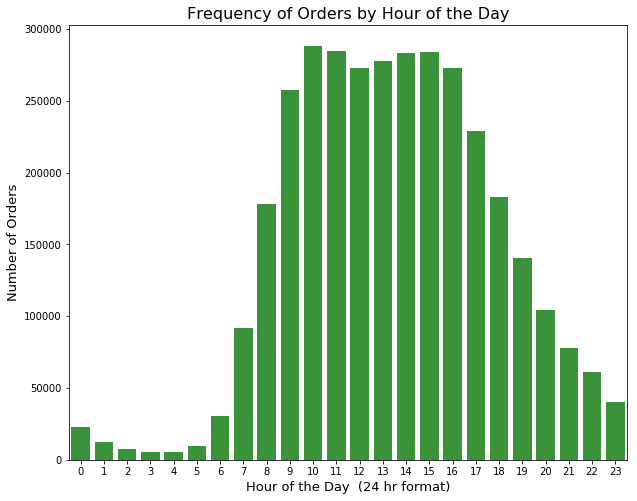

In [16]:
hist_count_plots(orders ,"order_hour_of_day", "Frequency of Orders by Hour of the Day",
                 "Hour of the Day  (24 hr format)", "Number of Orders", 2)

## Looking at Order Frequency by the days of the Week

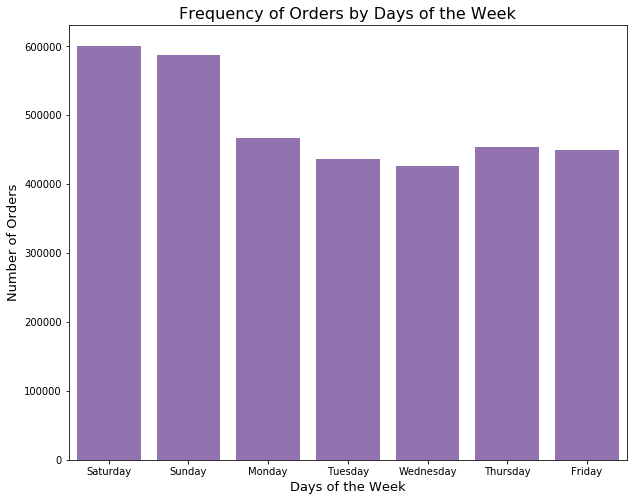

In [67]:
hist_count_plots(orders, "order_dow", "Frequency of Orders by Days of the Week",
                 "Days of the Week", "Number of Orders", 4)

## Continuous bivariate density of orders between day of the week and hour of the day

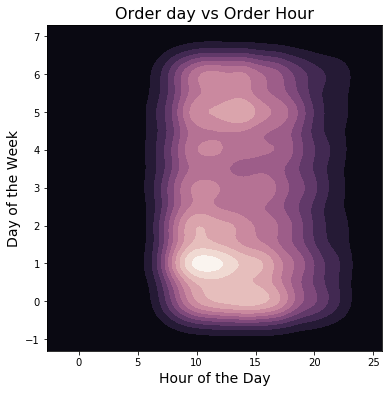

In [18]:
smallset = orders[0:10000]

f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(smallset.order_hour_of_day, smallset.order_dow, cmap=cmap, n_levels=15, shade=True);
plt.title("Order day vs Order Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Day of the Week", fontsize=14)
plt.show()

In [19]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [11]:
print(order_prior)

          order_id  product_id  add_to_cart_order  reordered
0                2       33120                  1          1
1                2       28985                  2          1
2                2        9327                  3          0
3                2       45918                  4          1
4                2       30035                  5          0
5                2       17794                  6          1
6                2       40141                  7          1
7                2        1819                  8          1
8                2       43668                  9          0
9                3       33754                  1          1
10               3       24838                  2          1
11               3       17704                  3          1
12               3       21903                  4          1
13               3       17668                  5          1
14               3       46667                  6          1
15               3      

## Distribution of departments and reorder rates.

We are interested to see if certain departments are the first items or last items to be ordered. 

This could affect which items we want to be showing in marketing materials

Perhaps people who order these items then go on to order more items


In [3]:
#We check if certain departments have higher reorder rates. 

MergedProductsDatabase = order_prior.merge(products, left_on='product_id', right_on='product_id', how='inner')[['department_id', 'add_to_cart_order']]
MergedProductsDatabase = MergedProductsDatabase.merge(departments, left_on = 'department_id', right_on='department_id', how='inner')[['department', 'add_to_cart_order']]

In [4]:
#What's the mean item number in the customer cart is items from each department
MergedProductsDatabaseMean = MergedProductsDatabase.groupby(['department'],as_index=False).mean().sort_values(by=['add_to_cart_order'])
print(MergedProductsDatabaseMean)



         department  add_to_cart_order
0           alcohol           5.428346
3         beverages           6.976699
7        dairy eggs           7.495423
18             pets           7.718544
19          produce           8.022875
2            bakery           8.084397
15            other           8.277645
5              bulk           8.399040
11        household           8.492163
13     meat seafood           8.528225
8              deli           8.693815
17    personal care           8.752753
10           frozen           8.996414
4         breakfast           9.124044
20           snacks           9.187743
14          missing           9.339489
16           pantry           9.593425
12    international           9.947061
6      canned goods           9.947258
9   dry goods pasta          10.212863
1            babies          10.575925


In [5]:
#What's the average item number in the customer cart is items from each department
MergedProductsDatabaseMedian = MergedProductsDatabase.groupby(['department'],as_index=False).median().sort_values(by=['add_to_cart_order'])
print(MergedProductsDatabaseMedian)

         department  add_to_cart_order
0           alcohol                  3
3         beverages                  5
18             pets                  6
2            bakery                  6
5              bulk                  6
15            other                  6
7        dairy eggs                  6
19          produce                  6
11        household                  6
17    personal care                  7
14          missing                  7
13     meat seafood                  7
10           frozen                  7
8              deli                  7
4         breakfast                  7
20           snacks                  7
9   dry goods pasta                  8
6      canned goods                  8
16           pantry                  8
12    international                  8
1            babies                  9


In [14]:
#Place code to construct graph here.
def vbar_plots_cartpositions(dframe1,dframe2, x_axis, _title, _xlabel, _ylabel, color_index):
    plt.figure(figsize=(10,5))
    plt.grid(True)
    sns.barplot(dframe1.iloc[:,0],dframe1.iloc[:,1],color="blue", alpha=0.5,saturation=.7, label='Median position')
    sns.barplot(dframe2.iloc[:,0],dframe2.iloc[:,1],color="green", alpha=0.5,saturation=.7, label = 'Mean position')
    plt.legend(loc='upper left')
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    plt.xticks( rotation=70, fontsize=13)
    plt.show()

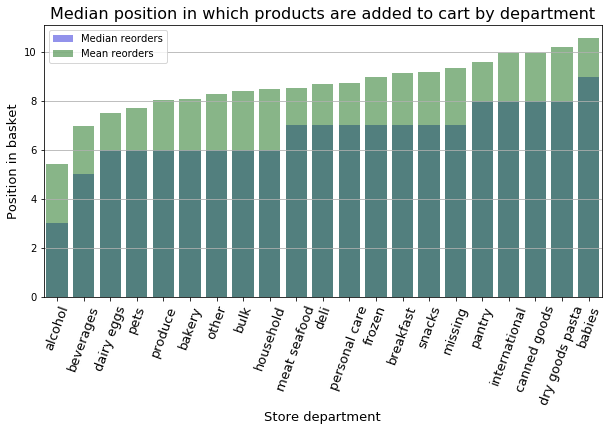

In [15]:
vbar_plots_cartpositions(MergedProductsDatabaseMedian,MergedProductsDatabaseMean, 'department', 'Median position in which products are added to cart by department','Store department','Position in basket', 2)